Weird: 
- When training the model on the chosen features, we get a really high score in the test set. But then, if we use a validation dataset selected with the latest entries, the model performance it is very bad. Of course we are selecting the features that give the higher score in the test set.
- How is the information leaking? Actually, having a split random, the information is passed based on the nearest point, it means, when several features has similar values, probably target will have as well. At least it is like that for 5 min targets where is continous
- i have to explore the current setup, we get more consistant score for the features obtained from df_info, but we also get higher peaks for random..

I have to think of a way of testing how good the model is against different periods

In [1]:
from src.modules.paths import get_project_root
import pandas as pd
from itertools import permutations

In [2]:
df = pd.read_csv(get_project_root() / "data" / "historical" / "xlmeur.csv")

In [3]:
base_columns = ["open", "close", "volume"]

In [4]:
operations = ["sum", "substract", "divide", "multiply"]

In [5]:
list_permutations_columns = list(permutations(base_columns, 2))

In [6]:
list_permutations_columns

[('open', 'close'),
 ('open', 'volume'),
 ('close', 'open'),
 ('close', 'volume'),
 ('volume', 'open'),
 ('volume', 'close')]

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split

def perform_operation(df, columns, operation):
    df = df.copy()
    if operation=="sum":
        out = df[columns[0]] + df[columns[1]]
    elif operation=="substract":
        out = df[columns[0]] - df[columns[1]]
    elif operation=="divide":
        out = df[columns[0]] / df[columns[1]]
    elif operation=="multiply":
        out = df[columns[0]] * df[columns[1]]
    return out

def fill_na(df):
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df.fillna(0)
def normalize(df, column_to_normalize):
    df = df.copy()
    for col in ["open", "close", "high", "low"]:
        df[f"{col}_norm"] = df[col] / df[column_to_normalize]
    
    return df
def generate_features(df):
    cont = 0
    list_feature_recipe = []
    base_columns = ["open_norm", "close_norm", "high_norm", "low_norm", "volume"]
    operations = ["sum", "substract", "divide", "multiply"]
    list_permutations_columns = list(permutations(base_columns, 2))
    # First level
    for columns in list_permutations_columns:
        for operation in operations:
            df[f"feature_{cont}"] = perform_operation(df, columns, operation)
            list_feature_recipe.append((cont, columns ,operation))
            cont +=1
    # second level
    #list_permutations_second_columns = list(permutations([col for col in df.columns if col.startswith("feature")],2))
    #for columns in list_permutations_second_columns:
    #    for operation in operations:
    #        #print(cont, columns, operations)
    #        df[f"feature_{cont}"] = perform_operation(df, columns, operation)
    #        cont +=1
                                       
    return df, list_feature_recipe

def to_float32(df):
    df = df.copy()
    feature_columns = [col for col in df.columns if col.startswith("feature")]
    df[feature_columns] = df[feature_columns].astype("float32")
    return df

def add_target(df, column_to_apply):
    df["target_1"] = df[column_to_apply].pct_change(-1)
    df["target_2"] = df[column_to_apply].pct_change(-2)
    df["target_5"] = df[column_to_apply].pct_change(-5)
    df["target_10"] = df[column_to_apply].pct_change(-10)
    df["target_20"] = df[column_to_apply].pct_change(-20)
    df["target_50"] = df[column_to_apply].pct_change(-50)
    return df

def pipeline():
    column_to_apply="open"
    df = pd.read_csv(get_project_root() / "data" / "historical" / "xlmeur.csv")
    df = normalize(df, column_to_normalize=column_to_apply)
    df, list_feature_recipe = generate_features(df)
    df = fill_na(df)
    df = to_float32(df)
    df = add_target(df, column_to_apply)
    df = add_domain_features(df, column_to_apply)
    df_validation=df.iloc[int(df.shape[0]*0.8):].dropna().copy()
    df = df.iloc[0:int(df.shape[0]*0.8)].copy()
    
    return df, list_feature_recipe, df_validation
    
def get_training_df(df):
    return df.dropna().reset_index().copy()

def get_df_info(run_info):
    # process run_info
    scores = [score for (score,_,_) in run_info]
    features = [features for (_,features,_) in run_info]
    importance = [importance for (_,_,importance) in run_info]
    pass

def update_info(run_info, df_info):
    scores = [score for (score,_,_) in run_info]
    features = [features for (_,features,_) in run_info]
    importance = [importance for (_,_,importance) in run_info]
    idx = scores.index(max(scores))
    df_info[features[idx]] += importance[idx]
    
    return df_info
            
def split_train_test(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test 

def get_best_columns(df_info, n):
    sorted_array=np.array(df_info.T.values).reshape(-1)
    df_info.T.iloc[sorted_array.argsort()[-n::]].T.columns
    return df_info.T.iloc[sorted_array.argsort()[-n::]].T.columns

def compute_RSI(df: pd.DataFrame, column_to_apply: str, interval_type="100s"):
    delta = df[column_to_apply].diff(1)
    delta.dropna(inplace=True)
    positive = delta.copy()
    negative = delta.copy()
    positive[positive<0] = 0
    negative[negative>0] = 0
    average_gain = positive.rolling(interval_type).mean()
    average_loss = abs(negative.rolling(interval_type).mean())
    relative_strength = average_gain /average_loss
    RSI = 100.0-(100.0/(1.0+relative_strength))
    #data[column_name] = RSI.copy()
    return RSI.copy()
def compute_MACD(df: pd.DataFrame, column_to_apply: str, min_half_life: str, max_half_life: str, mid_half_life:str):
    exp1 = df[column_to_apply].ewm(halflife=min_half_life).mean()
    exp2 = df[column_to_apply].ewm(halflife=max_half_life).mean()
    macd = exp1-exp2
    exp3 = macd.ewm(halflife=mid_half_life).mean()
    #df[f"macd"] = macd
    #df[f"signal"] = exp3
    #df["macd"] = macd.values-exp3.values
    #df["dummy_sign"]= df["macd_minus_signal"].apply(lambda x: 1 if x>0 else -1)
    #df[f"macd_minus_signal_diff_{min_half_life}_{max_half_life}_{mid_half_life}"] = df["dummy_sign"].diff(1)
    return macd.values-exp3.values

def compute_ewm(df, period, column_to_apply):
    
    out = df[column_to_apply].ewm(halflife=period,min_periods=0,adjust=False,ignore_na=False).mean()
    return out


def add_domain_features(df, column_to_apply):
    df = df.copy()
    cont=0
    ewm_list=[20,40,60,80,100,120,140,200,300]
    rsi_list=[50,100,200,300,400]
    macd_list = [(20,40,100), (40,80,200), (10,20,50), (80,160,100)]
    
    for ewm_coef in ewm_list:
        df[f"feature_domain_{cont}"]=compute_ewm(df=df, period=ewm_coef, column_to_apply=column_to_apply) / df[column_to_apply]
        cont+=1
        
    for rsi_coef in rsi_list:
        df[f"feature_domain_{cont}"]=compute_RSI(df=df, column_to_apply=column_to_apply, interval_type=rsi_coef)
        cont+=1
    for (min_half_life, max_half_life, mid_half_life) in macd_list:
        df[f"feature_domain_{cont}"]=compute_MACD(
            df=df,
            column_to_apply=column_to_apply,
            min_half_life=min_half_life,
            max_half_life=max_half_life,
            mid_half_life=mid_half_life
        )
        cont+=1 
    return df




In [28]:
df, list_feature_recipe, df_validation = pipeline()

In [29]:
df

,date,time,open,high,low,close,vwap,volume,count,open_norm,...,feature_domain_8,feature_domain_9,feature_domain_10,feature_domain_11,feature_domain_12,feature_domain_13,feature_domain_14,feature_domain_15,feature_domain_16,feature_domain_17
0,2021-09-23 06:11:00,1632377460,0.251290,0.251397,0.251114,0.251114,0.251198,31713.666001,8,1.0,...,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2021-09-23 06:12:00,1632377520,0.251114,0.251114,0.251114,0.251114,0.000000,0.000000,0,1.0,...,1.000699,NaN,NaN,NaN,NaN,NaN,-3.798432e-07,-1.902768e-07,-7.566468e-07,-9.497639e-08
2,2021-09-23 06:13:00,1632377580,0.251114,0.251114,0.251114,0.251114,0.000000,0.000000,0,1.0,...,1.000698,NaN,NaN,NaN,NaN,NaN,-4.152008e-07,-2.097185e-07,-8.129767e-07,-1.049419e-07
3,2021-09-23 06:14:00,1632377640,0.250800,0.250800,0.250467,0.250467,0.250603,1340.032089,4,1.0,...,1.001946,NaN,NaN,NaN,NaN,NaN,-1.947523e-06,-9.728627e-07,-3.898691e-06,-4.845549e-07
4,2021-09-23 06:15:00,1632377700,0.250467,0.250467,0.250467,0.250467,0.000000,0.000000,0,1.0,...,1.003271,NaN,NaN,NaN,NaN,NaN,-4.458824e-06,-2.225680e-06,-8.933816e-06,-1.107517e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7331,2021-09-28 08:22:00,1632817320,0.226870,0.226870,0.226870,0.226870,0.000000,0.000000,0,1.0,...,1.011362,59.821996,51.950099,43.363130,45.465067,47.798300,7.001469e-05,-4.331521e-04,4.818661e-04,-3.509314e-04
7332,2021-09-28 08:23:00,1632817380,0.227157,0.227157,0.226920,0.226920,0.226922,2203.685996,2,1.0,...,1.010061,61.236506,52.880672,44.040328,46.008542,48.252448,1.013669e-04,-4.139174e-04,5.126948e-04,-3.422804e-04
7333,2021-09-28 08:24:00,1632817440,0.226920,0.226920,0.226920,0.226920,0.000000,0.000000,0,1.0,...,1.011091,61.462694,52.566159,43.609736,45.235039,47.908265,1.270994e-04,-3.970973e-04,5.311922e-04,-3.347409e-04
7334,2021-09-28 08:25:00,1632817500,0.226920,0.226920,0.226920,0.226920,0.000000,0.000000,0,1.0,...,1.011065,61.462694,52.569672,43.609736,45.565418,47.908265,1.514833e-04,-3.806057e-04,5.463363e-04,-3.272789e-04


In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import TimeSeriesSplit

In [31]:
feature_columns = [col for col in df.columns if col.startswith("feature")] 
target_column="target_5"

In [32]:
df_train = get_training_df(df)

In [33]:
# time-series analysis
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
df_info = pd.DataFrame(0, index=[0],columns=feature_columns)
run_info_total = []
#weights = [1/len(feature_columns) for col in range(len(feature_columns))]
for _ in range(2):
    run_info = []
    print(_)
    for _ in range(2):
        #print(_)
        selected_features = random.choices(feature_columns, k=30)#, weights=weights)
        X, y = df_train[selected_features], df_train[target_column]
        cv = TimeSeriesSplit(n_splits=10)
        score =[]
        for train_index, test_index in cv.split(X):
            #print("Split", count_split)
            #count_split+=1
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y.loc[train_index], y.loc[test_index]
            rfr.fit(X_train, y_train)
            score.append(rfr.score(X_test, y_test))
        run_info.append((np.array(score).mean(), selected_features, rfr.feature_importances_) )
    #weights = get_next_weights(run_info)
    
    df_info = update_info(run_info, df_info)
    run_info_total.append(run_info)
    #df_info = get_df_info(run_info)



0
1


In [34]:
def get_metrics(model, X_validation, y_validation):
    dict_metrics = {
        #"test_score":model.score(X_test, y_test),
                    "validation_score": model.score(X_validation, y_validation)
    }
    return dict_metrics

In [35]:
combs = [(features,n_estimators,depth) for features in [19,20,21,10] for n_estimators in [40,50,60,70,100] for depth in [8,9,10,5,11]]

In [36]:
for (features,n_estimators,depth) in combs:
    # Define chosen_columns
    chosen_columns=get_best_columns(df_info,features)
    #chosen_columns=random.choices(feature_columns,k=features)
    # Define final model
    X_train, y_train = df_train[chosen_columns], df_train[target_column]
    X_validation, y_validation = df_validation[chosen_columns], df_validation[target_column]
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth=depth, random_state=1)
    rfr.fit(X_train, y_train)

    print(features,n_estimators,depth,get_metrics(rfr, X_validation, y_validation))



19 40 8 {'validation_score': 0.014724823283087773}
19 40 9 {'validation_score': 0.014265009048244237}
19 40 10 {'validation_score': 0.007641095266638809}
19 40 5 {'validation_score': 0.03101552694341725}
19 40 11 {'validation_score': 0.004607239994939616}
19 50 8 {'validation_score': 0.015853617768476713}
19 50 9 {'validation_score': 0.013831019409506928}
19 50 10 {'validation_score': 0.007941913929690014}
19 50 5 {'validation_score': 0.029988641938137772}
19 50 11 {'validation_score': 0.0028600000148347737}
19 60 8 {'validation_score': 0.018925846923375733}
19 60 9 {'validation_score': 0.01655644121573263}
19 60 10 {'validation_score': 0.010649385287441526}
19 60 5 {'validation_score': 0.03076173131198434}
19 60 11 {'validation_score': 0.0051624942791180795}
19 70 8 {'validation_score': 0.01826197590084}
19 70 9 {'validation_score': 0.013691098784693878}
19 70 10 {'validation_score': 0.007597209151315898}
19 70 5 {'validation_score': 0.030730609488486715}
19 70 11 {'validation_score':

In [127]:
run_info_total

[[(-0.31796423993717093,
   ['feature_22',
    'feature_19',
    'feature_domain_5',
    'feature_domain_8',
    'feature_domain_4',
    'feature_domain_6',
    'feature_13',
    'feature_19',
    'feature_14',
    'feature_20',
    'feature_11',
    'feature_domain_4',
    'feature_domain_4',
    'feature_17',
    'feature_23',
    'feature_21',
    'feature_9',
    'feature_7',
    'feature_domain_5',
    'feature_11',
    'feature_6',
    'feature_21',
    'feature_18',
    'feature_13',
    'feature_8',
    'feature_domain_4',
    'feature_domain_3',
    'feature_22',
    'feature_10',
    'feature_19'],
   array([0.00127987, 0.00244113, 0.03012103, 0.24961743, 0.0180859 ,
          0.07134653, 0.00193744, 0.0024768 , 0.00281334, 0.00715221,
          0.03030521, 0.02315789, 0.01706092, 0.00094648, 0.00074585,
          0.00259566, 0.15918146, 0.00159251, 0.03145921, 0.04202832,
          0.00107149, 0.0016754 , 0.00101791, 0.00255575, 0.06514063,
          0.01864271, 0.08313956, 

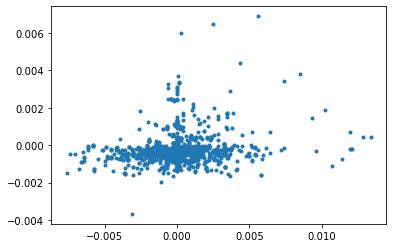

In [125]:
plt.plot(y_validation, rfr.predict(X_validation), ".")

In [126]:
feature_columns = [col for col in df.columns if col.startswith("feature")] 
target_column="target_5"

What is the idea? Have 2000 or so features, select random set of lets say 100 and save the results of score and the list of features that made it possible

In [128]:
df_train = get_training_df(df)

In [56]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
df_info = pd.DataFrame(0, index=[0],columns=feature_columns)
run_info_total = []
#weights = [1/len(feature_columns) for col in range(len(feature_columns))]
for _ in range(30):
    run_info = []
    for _ in range(10):
        selected_features = random.choices(feature_columns, k=10)#, weights=weights)
        X_train, X_test, y_train, y_test = split_train_test(df_train[selected_features], df_train[target_column])
        rfr.fit(X_train, y_train)
        run_info.append((rfr.score(X_test, y_test), selected_features, rfr.feature_importances_) )
    #weights = get_next_weights(run_info)
    
    df_info = update_info(run_info, df_info)
    run_info_total.append(run_info)
    #df_info = get_df_info(run_info)

KeyboardInterrupt: 

In [32]:
chosen_columns=get_best_columns(df_info,20)
print(chosen_columns)

Index(['feature_12', 'feature_domain_1', 'feature_16', 'feature_domain_8',
       'feature_20', 'feature_domain_5', 'feature_10', 'feature_2',
       'feature_domain_3', 'feature_4', 'feature_domain_6', 'feature_9',
       'feature_domain_4', 'feature_11', 'feature_domain_9', 'feature_1',
       'feature_domain_7', 'feature_8', 'feature_3', 'feature_0'],
      dtype='object')


In [100]:
# Score of 0.7 something is off
## ['feature_domain_6', 'feature_domain_4', 'feature_domain_5',
##       'feature_domain_2', 'feature_11', 'feature_domain_7', 'feature_3',
##       'feature_domain_1', 'feature_domain_0', 'feature_domain_9'],

In [33]:
rfr = RandomForestRegressor(n_estimators=200, max_depth=30)

In [34]:
df_train

,index,date,time,open,high,low,close,vwap,volume,count,...,feature_domain_0,feature_domain_1,feature_domain_2,feature_domain_3,feature_domain_4,feature_domain_5,feature_domain_6,feature_domain_7,feature_domain_8,feature_domain_9
0,400,2021-09-23 12:51:00,1632401460,0.249704,0.249974,0.249701,0.249974,0.249742,1282.799768,3,...,0.249272,0.249768,0.251203,48.310668,43.276540,42.614924,48.816771,0.000089,-0.000552,0.000376
1,401,2021-09-23 12:52:00,1632401520,0.249283,0.249283,0.249283,0.249283,0.249283,248.905328,2,...,0.249272,0.249760,0.251189,47.111871,42.721018,42.234748,48.638965,0.000097,-0.000544,0.000369
2,402,2021-09-23 12:53:00,1632401580,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,0,...,0.249272,0.249752,0.251176,47.405255,43.334793,42.234748,48.638965,0.000105,-0.000536,0.000362
3,403,2021-09-23 12:54:00,1632401640,0.249283,0.249283,0.249283,0.249283,0.000000,0.000000,0,...,0.249273,0.249744,0.251163,47.405255,43.422285,42.234748,48.867082,0.000112,-0.000528,0.000356
4,404,2021-09-23 12:55:00,1632401700,0.248767,0.248767,0.248767,0.248767,0.248767,872.247000,1,...,0.249255,0.249727,0.251146,45.997583,43.269091,41.777936,48.733876,0.000111,-0.000524,0.000333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,5071,2021-09-26 18:42:00,1632681720,0.238406,0.238406,0.238406,0.238406,0.000000,0.000000,0,...,0.238077,0.238027,0.237384,52.293701,53.077277,54.579233,52.656349,-0.000205,-0.000178,0.000027
4672,5072,2021-09-26 18:43:00,1632681780,0.238406,0.238406,0.238406,0.238406,0.000000,0.000000,0,...,0.238088,0.238034,0.237391,52.293701,53.079718,54.490722,53.025884,-0.000199,-0.000177,0.000033
4673,5073,2021-09-26 18:44:00,1632681840,0.238406,0.238406,0.238406,0.238406,0.000000,0.000000,0,...,0.238099,0.238040,0.237398,51.469388,52.562552,55.020411,52.580734,-0.000193,-0.000176,0.000039
4674,5074,2021-09-26 18:45:00,1632681900,0.238406,0.238406,0.238406,0.238406,0.000000,0.000000,0,...,0.238109,0.238046,0.237405,49.253094,52.562552,55.020411,52.580734,-0.000188,-0.000176,0.000044


In [35]:
X_train, X_test, y_train, y_test = split_train_test(df_train[chosen_columns], df_train[target_column])
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=200)

Conclusions: if we set to a minimum of 5 features, then if we add new features to the final model does not necessarily mean it will perform better. Do not undertsand why

In [36]:
rfr.score(X_test, y_test)

0.61830564725491

In [74]:
y_pred = rfr.predict(X_test)

In [147]:
rfr.feature_importances_

array([0.12956908, 0.10568546, 0.08932477, 0.11805266, 0.06081551,
       0.12509174, 0.06118848, 0.08969132, 0.09158939, 0.1289916 ])

In [142]:
y_pred

array([ 0.00318279, -0.00179008, -0.00088369, ..., -0.00291973,
       -0.00162881,  0.00118343])

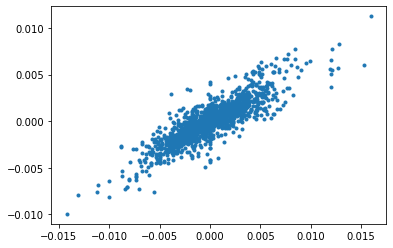

In [96]:
plt.plot(y_test, y_pred, ".")

In [148]:
df_validation

,date,time,open,high,low,close,vwap,volume,count,feature_0,...,feature_domain_1,feature_domain_2,feature_domain_3,feature_domain_4,feature_domain_5,feature_domain_6,feature_domain_7,feature_domain_8,feature_domain_9,pred_5
5000,2021-09-26 17:31:00,1632677460,0.237774,0.237774,0.237774,0.237774,0.000000,0.000000,0,0.475548,...,0.238006,0.236978,48.694225,55.124694,51.088914,55.532643,-0.000182,0.000096,-0.000109,-0.000661
5001,2021-09-26 17:32:00,1632677520,0.238027,0.238027,0.238027,0.238027,0.238027,898.287680,1,0.476054,...,0.238006,0.236985,49.644819,55.421902,51.434638,55.787047,-0.000187,0.000090,-0.000115,-0.000350
5002,2021-09-26 17:33:00,1632677580,0.238027,0.238027,0.238027,0.238027,0.000000,0.000000,0,0.476054,...,0.238007,0.236992,49.644819,55.168317,51.434638,55.787047,-0.000192,0.000085,-0.000120,-0.000540
5003,2021-09-26 17:34:00,1632677640,0.238027,0.238027,0.238027,0.238027,0.000000,0.000000,0,0.476054,...,0.238007,0.236999,47.968218,55.168317,51.434638,55.557682,-0.000196,0.000079,-0.000125,-0.000525
5004,2021-09-26 17:35:00,1632677700,0.237740,0.237740,0.237740,0.237740,0.237740,37.614300,1,0.475480,...,0.238002,0.237004,45.178325,54.340502,51.297055,55.168620,-0.000205,0.000071,-0.000138,-0.000260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6341,2021-09-27 15:52:00,1632757920,0.232382,0.232382,0.232382,0.232382,0.000000,0.000000,0,0.464764,...,0.233630,0.234798,43.032254,46.031864,43.449037,44.524514,-0.000207,-0.000480,-0.000069,0.000166
6342,2021-09-27 15:53:00,1632757980,0.232382,0.232382,0.232382,0.232382,0.000000,0.000000,0,0.464764,...,0.233609,0.234781,43.032254,46.031864,43.449037,44.524514,-0.000208,-0.000481,-0.000069,0.000172
6343,2021-09-27 15:54:00,1632758040,0.232382,0.232382,0.232382,0.232382,0.000000,0.000000,0,0.464764,...,0.233588,0.234765,43.171257,44.741165,43.383675,44.152474,-0.000208,-0.000483,-0.000069,-0.000141
6344,2021-09-27 15:55:00,1632758100,0.232382,0.232382,0.232382,0.232382,0.000000,0.000000,0,0.464764,...,0.233567,0.234748,43.171257,44.741165,43.383675,44.230065,-0.000208,-0.000484,-0.000067,-0.000103


In [37]:
rfr.predict(df_validation[chosen_columns])

array([ 0.00122585,  0.00120135, -0.00028735, ..., -0.00052419,
       -0.00056127,  0.00054251])

In [38]:
#df.loc[ X_test.index, "pred_5"] = rfr.predict(X_test)
df_validation["pred_5"] = rfr.predict(df_validation[chosen_columns])

-0.0025882650759598835


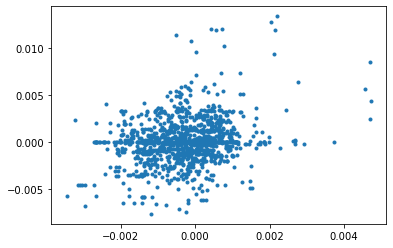

In [39]:
plt.plot(df_validation.pred_5, df_validation.target_5, ".")
df_score = df_validation.dropna()
print(r2_score(df_score.target_5,df_score.pred_5))

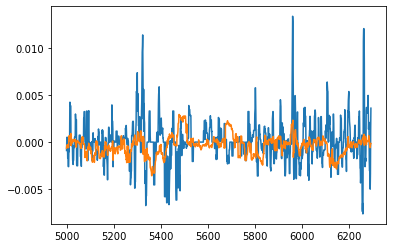

In [145]:
plt.plot(df_score.target_5)
plt.plot(df_score.pred_5)

In [173]:
X_train["is_train"] =True
X_test["is_train"] = False
X_train["y"] = y_train
X_test["y"] = y_test

X_training = pd.concat([X_train, X_test])


In [174]:
X_training["index"] =X_training.index


In [175]:
X_training.sort_values(by="index")

,feature_domain_6,feature_domain_4,feature_domain_5,feature_domain_2,feature_11,feature_domain_7,feature_3,feature_domain_1,feature_domain_0,feature_domain_9,is_train,y,is_test,index
400,48.816771,43.276540,42.614924,0.251203,0.062420,0.000089,0.062420,0.249768,0.249272,0.000376,True,0.001588,NaN,400
401,48.638965,42.721018,42.234748,0.251189,0.062142,0.000097,0.062142,0.249760,0.249272,0.000369,True,-0.000100,NaN,401
402,48.638965,43.334793,42.234748,0.251176,0.062142,0.000105,0.062142,0.249752,0.249272,0.000362,True,-0.000100,NaN,402
403,48.867082,43.422285,42.234748,0.251163,0.062142,0.000112,0.062142,0.249744,0.249273,0.000356,True,-0.000100,NaN,403
404,48.733876,43.269091,41.777936,0.251146,0.061885,0.000111,0.061885,0.249727,0.249255,0.000333,True,-0.002170,NaN,404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4945,52.937860,52.567897,54.628433,0.236451,0.056583,0.000066,0.056583,0.237783,0.238279,-0.000128,False,0.000059,False,4945
4946,53.916987,52.567897,54.628433,0.236460,0.056583,0.000050,0.056583,0.237784,0.238265,-0.000149,False,0.000063,False,4946
4947,53.881369,52.585658,54.663333,0.236470,0.056596,0.000035,0.056596,0.237786,0.238253,-0.000167,False,0.000181,False,4947
4948,53.970145,52.585658,54.663333,0.236480,0.056596,0.000021,0.056596,0.237788,0.238241,-0.000182,False,0.000181,False,4948


Useful for explaing the need of timeseries fold

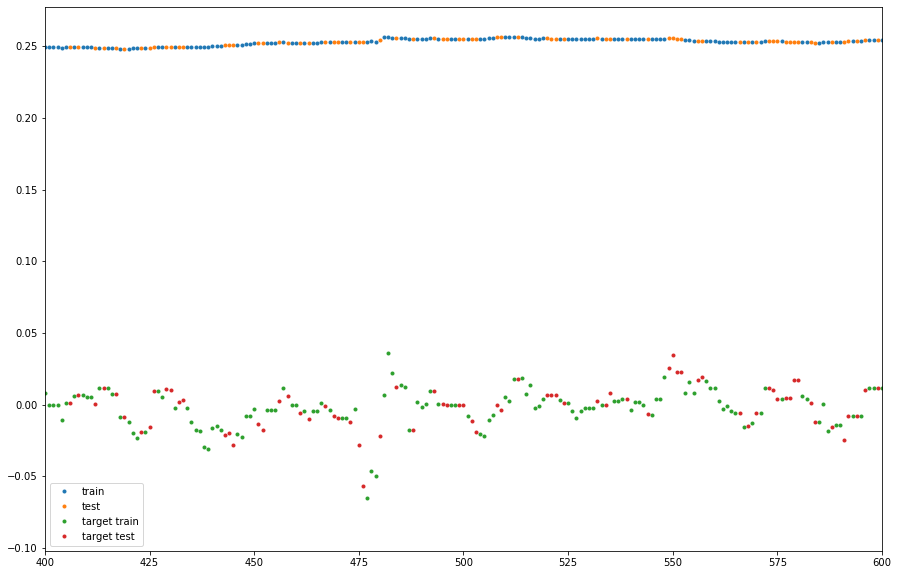

In [222]:
df_an = df.copy()
df_an.loc[X_train.index, "train"] = True
df_an.loc[X_test.index, "train"] = False
plt.figure(figsize=(15,10))
plt.plot(df_an[df_an.train==True].open, ".", label="train")
plt.plot(df_an[df_an.train==False].open, ".", label="test")
plt.plot(df_an[df_an.train==True].target_5*5, ".", label="target train")
plt.plot(df_an[df_an.train==False].target_5*5, ".", label="target test")
plt.legend()
plt.xlim([400,600])
plt.show()
Rbreak here
for feature in chosen_columns:
    plt.plot(df_an[df_an.train==True][feature], ".", label=f"{feature} train")
    plt.plot(df_an[df_an.train==False][feature], ".", label=f"{feature} test")
    plt.xlim([400,600])
    plt.show()



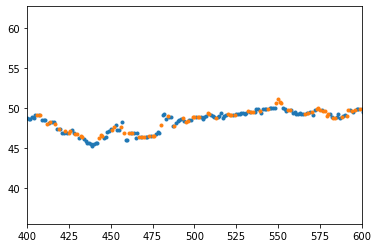

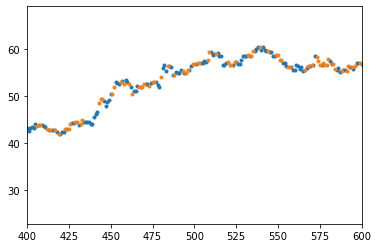

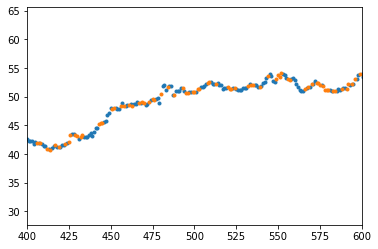

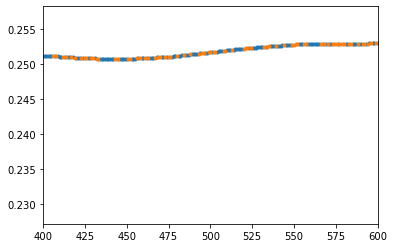

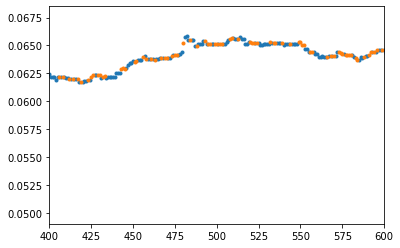

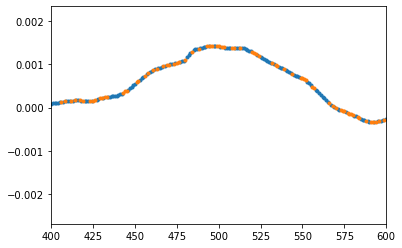

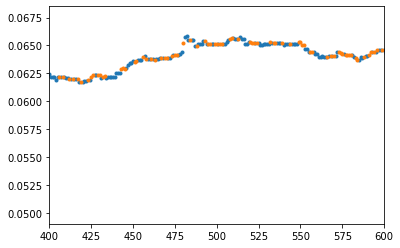

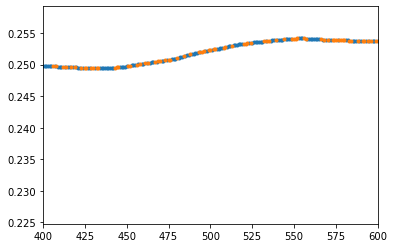

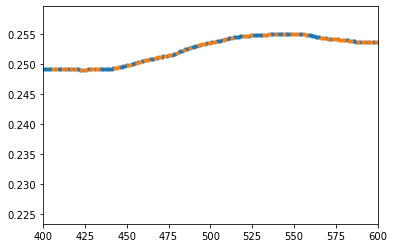

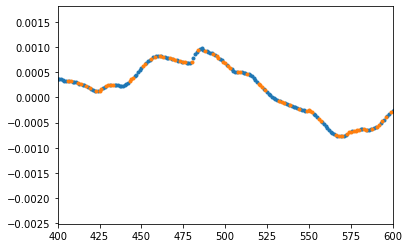